# This script performs the equity calculation that is generally to be used in the figures and results of the paper. It should then be followed by script '03_...' starting not from the beginning but skipping the first few cells. 

In [1]:
%matplotlib inline
import numpy as np
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from scipy import integrate
import seaborn as sns
import itertools
from matplotlib.lines import Line2D
import matplotlib.pylab as plb
from sklearn.linear_model import LinearRegression
import matplotlib.style as style
from matplotlib.patches import Patch

data_path = ""
plot_path = ""
table_path = ""

pd.set_option('display.max_columns', 500)

In [2]:

main_remind=pd.read_excel(data_path+'REMIND_prepINPUT_use.xls')
main_image=pd.read_excel(data_path+'IMAGE_prepINPUT_use.xls')
main_message=pd.read_excel(data_path+'MESSAGE_prepINPUT_use.xls')


In [3]:
main_remind = main_remind.drop(columns='Unnamed: 0')
main_image = main_image.drop(columns='Unnamed: 0')
main_message = main_message.drop(columns='Unnamed: 0')

main_remind.columns

Index(['MODEL', 'Region', 'Scenario', 'Year', 'Total_CO2', 'Total_GHG',
       'BECCS', 'LANDCDR', 'TOTAL_CDR', 'CO2_Emissions', 'CUM_CO2', 'CUM_CDR',
       'Unit_CO2', 'Population', 'GDP', 'Unit_Population', 'cumPopulation',
       '2016_emissions', 'em_change'],
      dtype='object')

In [4]:
# Sum regions up to match REMIND regions

main_reg_image = main_image.copy()
main_reg_message = main_message.copy()


sumColums = ['Total_CO2', 'Total_GHG', 'BECCS', 'LANDCDR',
       'TOTAL_CDR', 'CO2_Emissions', 'CUM_CO2', 'CUM_CDR',
       'Population', 'GDP', 'cumPopulation']
mask_reg = (main_reg_image.Region.isin(['EAF', 'RSAF', 'SAF', 'WAF']))
for sce in main_reg_image.Scenario.unique():
    mask_sce = (main_reg_image.Scenario == sce)
    for year in main_reg_image.Year.unique():
        mask_year = (main_reg_image.Year == year)
        filtered_df = main_reg_image.loc[mask_sce & mask_reg & mask_year,:]
        result = main_reg_image.loc[mask_sce & mask_reg & mask_year,sumColums].sum(axis=0)
        idx = len(main_reg_image)+1
        main_reg_image.loc[idx,:] = filtered_df.iloc[1]
        main_reg_image.loc[idx,sumColums] = result
        main_reg_image.loc[idx,'Region'] = 'AFR'
        
mask_reg = (main_reg_image.Region.isin(['NAF', 'ME']))
for sce in main_reg_image.Scenario.unique():
    mask_sce = (main_reg_image.Scenario == sce)
    for year in main_reg_image.Year.unique():
        mask_year = (main_reg_image.Year == year)
        filtered_df = main_reg_image.loc[mask_sce & mask_reg & mask_year,:]
        result = main_reg_image.loc[mask_sce & mask_reg & mask_year,sumColums].sum(axis=0)
        idx = len(main_reg_image)+1
        main_reg_image.loc[idx,:] = filtered_df.iloc[0]
        main_reg_image.loc[idx,sumColums] = result
        main_reg_image.loc[idx,'Region'] = 'MEA'

        
mask_reg = (main_reg_image.Region.isin(['RSAM', 'RCAM', 'MEX', 'BRA']))
for sce in main_reg_image.Scenario.unique():
    mask_sce = (main_reg_image.Scenario == sce)
    for year in main_reg_image.Year.unique():
        mask_year = (main_reg_image.Year == year)
        filtered_df = main_reg_image.loc[mask_sce & mask_reg & mask_year,:]
        result = main_reg_image.loc[mask_sce & mask_reg & mask_year,sumColums].sum(axis=0)
        idx = len(main_reg_image)+1
        main_reg_image.loc[idx,:] = filtered_df.iloc[0]
        main_reg_image.loc[idx,sumColums] = result
        main_reg_image.loc[idx,'Region'] = 'LAM'
        
mask_reg = (main_reg_image.Region.isin(['CEU', 'WEU']))
for sce in main_reg_image.Scenario.unique():
    mask_sce = (main_reg_image.Scenario == sce)
    for year in main_reg_image.Year.unique():
        mask_year = (main_reg_image.Year == year)
        filtered_df = main_reg_image.loc[mask_sce & mask_reg & mask_year,:]
        result = main_reg_image.loc[mask_sce & mask_reg & mask_year,sumColums].sum(axis=0)
        idx = len(main_reg_image)+1
        main_reg_image.loc[idx,:] = filtered_df.iloc[0]
        main_reg_image.loc[idx,sumColums] = result
        main_reg_image.loc[idx,'Region'] = 'EUR'


        
# Make Region-Column universal

#Image: INDIA -> IND
#       JAP -> JPN
#Message: R11_AFR -> AFR
#         EU -> EUR
#         R11_LAM -> LAM
#         R11_MEA -> MEA
#         R11_FSU -> RUS
       
main_reg_image = main_reg_image.replace('INDIA', 'IND')
main_reg_image = main_reg_image.replace('JAP', 'JPN')

main_reg_message = main_reg_message.replace('R11_AFR', 'AFR')
main_reg_message = main_reg_message.replace('EU', 'EUR')
main_reg_message = main_reg_message.replace('R11_LAM', 'LAM')
main_reg_message = main_reg_message.replace('R11_MEA', 'MEA')
main_reg_message = main_reg_message.replace('R11_FSU', 'RUS')
main_reg_message = main_reg_message.replace('R11_PAO', 'PAO')
main_reg_message = main_reg_message.replace('R11_PAS', 'PAS')

In [5]:
# Delete rows in dataframe that are not the same as remind model 
main_equal_image = main_reg_image.copy()
indexNames = main_reg_image[(main_reg_image['Region'] == 'CAN') + (main_reg_image['Region'] == 'INDO') 
                              + (main_reg_image['Region'] == 'JPN') + (main_reg_image['Region'] == 'KOR') +
                             (main_reg_image['Region'] == 'ME') + (main_reg_image['Region'] == 'OCE') +
                             (main_reg_image['Region'] == 'RSAS') + (main_reg_image['Region'] == 'SEAS') +
                             (main_reg_image['Region'] == 'STAN') + (main_reg_image['Region'] == 'TUR') +
                             (main_reg_image['Region'] == 'BRA') + (main_reg_image['Region'] == 'UKR') +
                             (main_reg_image['Region'] == 'CEU') + (main_reg_image['Region'] == 'EAF') +
                             (main_reg_image['Region'] == 'MEX') + (main_reg_image['Region'] == 'NAF') +
                             (main_reg_image['Region'] == 'RCAM')+ (main_reg_image['Region'] == 'RSAF') +
                             (main_reg_image['Region'] == 'RSAM')+ (main_reg_image['Region'] == 'SAF') +
                             (main_reg_image['Region'] == 'WAF') + (main_reg_image['Region'] == 'WEU')].index
main_equal_image.drop(indexNames, inplace=True)


main_equal_message = main_reg_message.copy()
indexNames = main_reg_message[
                             (main_reg_message['Region'] == 'PAO') + (main_reg_message['Region'] == 'PAS')].index
#(main_reg_message['Region'] == 'MEA') + 
main_equal_message.drop(indexNames, inplace=True)



main_equal_remind = main_remind.copy()
indexNames = main_remind[(main_remind['Region'] == 'JPN') 
                              + (main_remind['Region'] == 'OAS') + (main_remind['Region'] == 'ROW')].index
#+ (main_remind['Region'] == 'MEA') 
main_equal_remind.drop(indexNames, inplace=True)


allmodels_equal_df = main_equal_remind.append(main_equal_image)
allmodels_equal_df = allmodels_equal_df.append(main_equal_message)

indexNames = allmodels_equal_df[(allmodels_equal_df['Region'] == 'PAO') 
                              + (allmodels_equal_df['Region'] == 'PAS')+ (allmodels_equal_df['Region'] == 'MEA')].index
#+ (main_remind['Region'] == 'MEA') 
allmodels_equal_df.drop(indexNames, inplace=True)

print(allmodels_equal_df.Region.unique())

['AFR' 'CHN' 'EUR' 'IND' 'LAM' 'RUS' 'USA' 'World']


/Users/susannebaur/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


In [6]:
print(main_equal_remind.Region.unique())
print(main_equal_image.Region.unique())
print(main_equal_message.Region.unique())

['AFR' 'CHN' 'EUR' 'IND' 'LAM' 'MEA' 'RUS' 'USA' 'World']
['CHN' 'IND' 'RUS' 'USA' 'World' 'AFR' 'MEA' 'LAM' 'EUR']
['CHN' 'EUR' 'IND' 'AFR' 'RUS' 'LAM' 'MEA' 'USA' 'World']


In [7]:
regions = ['AFR', 'CHN', 'EUR', 'IND', 'LAM', 'RUS', 'USA', 'World']
regions_no_world = ['AFR', 'CHN', 'EUR', 'IND', 'LAM', 'RUS', 'USA']

def GDP_cap_calc(main_df, regions_names):
    main_df['GDP'] = main_df['GDP']#*1000
    main_df['Unit_GDP'] = 'USD Billion'
    main_df['GDP_cap'] = 0
    main_df['GDP_cap_avg'] = 0
    wfilt = (main_df.Region == 'World')

    for scen in main_df.Scenario.unique():
            rfilt=(main_df.Region.isin(regions_names))
            sfilt=(main_df.Scenario==scen)

            for yr in main_df.Year.unique(): 
                yrfilt=(main_df.Year==yr)
                main_df.loc[sfilt&yrfilt&rfilt,
                            'GDP_cap'] = main_df.loc[
                    rfilt&yrfilt&sfilt,'GDP'].values/main_df.loc[rfilt&yrfilt&sfilt,'Population'].values  
                main_df.loc[sfilt&yrfilt&rfilt,
                            'GDP_cap_avg'] = sum(main_df.loc[wfilt&sfilt&yrfilt, 'GDP_cap'])
    return main_df

main_image = GDP_cap_calc(main_equal_image, regions)
main_remind = GDP_cap_calc(main_equal_remind, regions)
main_message = GDP_cap_calc(main_equal_message, regions)

In [8]:
main_image.Scenario.unique()

array(['SSP1-19-SPA0-V17', 'SSP2-LF-SPA2-V17'], dtype=object)

In [9]:
def CoI_calc(main_df):

    mask = (main_df['GDP_cap'].values > main_df['GDP_cap_avg'].values)

    main_df['GDP_cap_CoI_nan'] = np.where(mask, main_df['GDP_cap'], np.nan)
    main_df['GDP_cap_CoI'] = np.where(mask, main_df['GDP_cap'], 0)
    main_df['GDP_CoI_nan'] = np.where(mask, main_df['GDP'], np.nan)
    main_df['GDP_CoI'] = np.where(mask, main_df['GDP'], 0)

    return main_df

main_image = CoI_calc(main_image)
main_remind = CoI_calc(main_remind)
main_message = CoI_calc(main_message)

In [10]:
# Alternative GDP EQUITY CALCULATION
regions = ['AFR', 'CHN', 'EUR', 'IND', 'LAM', 'RUS', 'USA', 'World']
regions_no_world = ['AFR', 'CHN', 'EUR', 'IND', 'LAM', 'RUS', 'USA']

def GDP_eq_Winkler(main_df, regions_names):
    main_df['zahler'] = 0
    main_df['nenner'] = 0
    for scen in main_df.Scenario.unique():
            #rfilt=(main_df.Region.isin(regions_names))
            wfilt = (main_df.Region == 'World')
            sfilt=(main_df.Scenario==scen)
            
            for yr in main_df.Year.unique(): 
                yrfilt= (main_df.Year == yr)
                rfilt=(main_df.Region.isin(regions_names))
                main_df.loc[sfilt&yrfilt&rfilt,
                                            'nenner'] = sum((main_df.loc[
                                    rfilt&yrfilt&sfilt,'Population'].values/main_df.loc[wfilt&yrfilt&sfilt,'Population'].values) * main_df.loc[rfilt&yrfilt&sfilt,'GDP_cap'].values)
                
                    

    return main_df      
               
                            
main_image = GDP_eq_Winkler(main_image, regions_no_world)
main_remind = GDP_eq_Winkler(main_remind, regions_no_world)
main_message = GDP_eq_Winkler(main_message, regions_no_world)


In [11]:

def GDP_eq_zahler(main_df, regions_names):
    for scen in main_df.Scenario.unique():
            #rfilt=(main_df.Region.isin(regions_names))
            wfilt = (main_df.Region == 'World')
            sfilt=(main_df.Scenario==scen)
            
            for yr in main_df.Year.unique(): 
                yrfilt= (main_df.Year == yr)
                rfilt=(main_df.Region.isin(regions_names))
                
                main_df['Tot_CDR'] = 0
                
             #   main_df.loc[sfilt & yrfilt & rfilt, 'Tot_CDR'] = main_df.loc[sfilt & yrfilt & wfilt, 'TOTAL_CDR']
                
              #  print(main_df.loc[sfilt & yrfilt & rfilt, 'Tot_CDR'])
               # print(main_df.loc[sfilt & yrfilt & wfilt, 'TOTAL_CDR'])
                
                for reg in main_df.Region.unique():
                    reg_filt = (main_df.Region == reg)
                 #   main_df.loc[sfilt & yrfilt & reg_filt, 'Tot_CDR'] = main_df.loc[sfilt & yrfilt & wfilt, 'TOTAL_CDR'].values
                    main_df.loc[sfilt&yrfilt&reg_filt,'zahler'] = (main_df.loc[sfilt&yrfilt&reg_filt, 
                                                                                   'Population'].values/main_df.loc[wfilt&yrfilt&sfilt,'Population'].values) * main_df.loc[reg_filt&yrfilt&sfilt,'GDP_cap'].values
                    main_df.loc[sfilt&yrfilt&reg_filt,'M'] = (main_df.loc[sfilt&yrfilt&reg_filt, 
                                                                                   'zahler'] / main_df.loc[sfilt&yrfilt&reg_filt, 
                                                                                   'nenner']) * main_df.loc[sfilt&yrfilt&wfilt, 
                                                                                   'TOTAL_CDR'].values
    return main_df
                    
    

main_image = GDP_eq_zahler(main_image, regions_no_world)       
main_remind = GDP_eq_zahler(main_remind, regions_no_world)      
main_message = GDP_eq_zahler(main_message, regions_no_world)      


In [65]:
main_image.loc[main_image.Scenario == 'SSP1-19-SPA0-V17']
main_image.to_excel(data_path+'IMAGE_equity_GDP_WINKLER.xls')

In [12]:
print(main_image.Region.unique())
print(main_remind.Region.unique())
print(main_message.Region.unique())

['CHN' 'IND' 'RUS' 'USA' 'World' 'AFR' 'MEA' 'LAM' 'EUR']
['AFR' 'CHN' 'EUR' 'IND' 'LAM' 'MEA' 'RUS' 'USA' 'World']
['CHN' 'EUR' 'IND' 'AFR' 'RUS' 'LAM' 'MEA' 'USA' 'World']


In [32]:


def GDP_CoI_frac_calc(main_df, regions_names_noworld):    
    main_df['GDP_CoI_frac'] = 0
    main_df['CDR_per_cap_GDP'] = 0
    main_df['CDR_per_cap_per_GDP_per_cap'] = 0

    for scen in main_df.Scenario.unique():
            rfilt=(main_df.Region.isin(regions_names_noworld))
            sfilt=(main_df.Scenario==scen)

            for yr in main_df.Year.unique(): 
                yrfilt=(main_df.Year==yr)
                tot_GDP_yr = main_df.loc[sfilt&yrfilt&rfilt,
                            'GDP_CoI'].sum()
                main_df.loc[sfilt&yrfilt&rfilt,
                            'GDP_CoI_frac'] = (main_df.loc[rfilt&sfilt&yrfilt,'GDP_CoI'])/tot_GDP_yr
                main_df.loc[sfilt&yrfilt&rfilt,
                            'CDR_fair_share_by_GDP'] = (main_df.loc[rfilt&sfilt&yrfilt,'GDP_CoI_frac'])*(main_df.loc[sfilt&yrfilt&(main_df.Region=='World'),'TOTAL_CDR'].values)
                main_df.loc[sfilt&yrfilt&rfilt, 
                            'CDR_per_cap_GDP'] = (main_df.loc[rfilt&sfilt&yrfilt,'CDR_fair_share_by_GDP'])/(main_df.loc[sfilt&yrfilt&rfilt,'Population'].values)
                main_df.loc[sfilt&yrfilt&rfilt, 
                            'CDR_per_cap_per_GDP_per_cap'] = (main_df.loc[rfilt&sfilt&yrfilt,'CDR_per_cap_GDP'])/(main_df.loc[sfilt&yrfilt&rfilt,'GDP_cap'].values)
               
                                                                      
    
    main_df['CUM_CDR_fair_share_by_GDP'] = 0
    main_df['Cum_M'] = 0
    for scen in main_df.Scenario.unique():
        for reg in main_df.Region.unique():
            main_df.loc[(main_df.Year == 2020), 'CUM_CDR_fair_share_by_GDP'] = main_df.loc[(main_df.Year == 2020), 'CDR_fair_share_by_GDP'] 
            main_df.loc[(main_df.Year == 2020), 'Cum_M'] = main_df.loc[(main_df.Year == 2020), 'M'] 

    for reg in main_df.Region.unique():
        if reg in regions_names_noworld:
            mask = main_df.Region == reg
            full_reg = main_df.loc[mask,:]

            for scen in full_reg.Scenario.unique():
                mask_scen = full_reg.Scenario == scen
                full_scen = full_reg.loc[mask_scen,:]
                integral = integrate.cumtrapz(y = full_scen.CDR_fair_share_by_GDP, x = full_scen.Year, initial = 0)
                full_reg.loc[mask_scen,'CUM_CDR_fair_share_by_GDP'] += integral
                inte_M = integrate.cumtrapz(y = full_scen.M, x = full_scen.Year, initial = 0)
                full_reg.loc[mask_scen,'Cum_M'] += inte_M
            main_df.loc[mask,'CUM_CDR_fair_share_by_GDP'] = full_reg.loc[:,'CUM_CDR_fair_share_by_GDP']
            main_df.loc[mask,'Cum_M'] = full_reg.loc[:,'Cum_M']
            
    
    return main_df

main_remind = GDP_CoI_frac_calc(main_remind, regions_no_world)
main_image = GDP_CoI_frac_calc(main_image, regions_no_world)
main_message = GDP_CoI_frac_calc(main_message, regions_no_world)

In [34]:
main_remind

,MODEL,Region,Scenario,Year,Total_CO2,Total_GHG,BECCS,LANDCDR,TOTAL_CDR,CO2_Emissions,CUM_CO2,CUM_CDR,Unit_CO2,Population,GDP,Unit_Population,cumPopulation,2016_emissions,em_change,Unit_GDP,GDP_cap,GDP_cap_avg,GDP_cap_CoI_nan,GDP_cap_CoI,GDP_CoI_nan,GDP_CoI,zahler,nenner,Tot_CDR,M,GDP_CoI_frac,CDR_per_cap_GDP,CDR_per_cap_per_GDP_per_cap,CDR_fair_share_by_GDP,CUM_CDR_fair_share_by_GDP,Global_CUM_CO2_by_CUM_POP,Fair_share_by_CUM_POP,Excess_emissions_by_CUM_POP,Exc_em_fac_by_CUM_POP,CDR_fair_share_by_CUM_POP,CUM_CDR_fair_share_by_CUM_POP,CDR_model_vs_fair_share_by_CUM_POP,CDR_model_vs_fair_share_by_GDP,CUM_CDR_model_vs_fair_share_by_CUM_POP,CUM_CDR_model_vs_fair_share_by_GDP,Cum_M
0,REMIND,AFR,SSP1-19-SPA1-V17,2020,1215.4939,3233.0,0.0060,222.6215,222.6275,3455.6275,9.828953e+04,222.6275,Mt/yr,996.7,2288,Mio,21023.288404,3127.643169,1.104866,USD Billion,2.295575,13.416413,NaN,0.000000,NaN,0,0.303328,9.954925,0,21.045240,0.000000,0.000000,0.000000,0.000000,0.000000,6.797535,1.429065e+05,-4.461702e+04,NaN,0.000000,0.000000,-222.627500,-222.627500,-222.627500,-222.627500,2.104524e+01
1,REMIND,AFR,SSP1-19-SPA1-V17,2030,1212.0330,2952.0,30.8600,77.8637,108.7237,3060.7237,1.308713e+05,1879.3835,Mt/yr,1181.0,4293,Mio,31911.788404,3127.643169,0.978604,USD Billion,3.635055,18.619143,NaN,0.000000,NaN,0,0.535020,13.996635,0,29.321826,0.000000,0.000000,0.000000,0.000000,0.000000,6.475300,2.066384e+05,-7.576711e+04,NaN,0.000000,0.000000,-108.723700,-108.723700,-1879.383500,-1879.383500,2.518353e+02
2,REMIND,AFR,SSP1-19-SPA1-V17,2040,1618.5552,3692.0,352.2000,21.3519,373.5519,4065.5519,1.665027e+05,4290.7615,Mt/yr,1351.0,8860,Mio,44571.788404,3127.643169,1.299877,USD Billion,6.558105,25.680048,NaN,0.000000,NaN,0,1.061714,19.381786,0,217.586138,0.000000,0.000000,0.000000,0.000000,0.000000,5.933099,2.644488e+05,-9.794619e+04,NaN,0.000000,0.000000,-373.551900,-373.551900,-4290.761500,-4290.761500,1.486375e+03
3,REMIND,AFR,SSP1-19-SPA1-V17,2050,388.3696,2444.0,949.0000,28.5074,977.5074,3421.5074,2.039380e+05,11046.0580,Mt/yr,1488.0,17450,Mio,58766.788404,3127.643169,1.093957,USD Billion,11.727151,33.297960,NaN,0.000000,NaN,0,2.057540,24.999293,0,809.706971,0.000000,0.000000,0.000000,0.000000,0.000000,5.380471,3.161930e+05,-1.122550e+05,NaN,0.000000,0.000000,-977.507400,-977.507400,-11046.058000,-11046.058000,6.622841e+03
4,REMIND,AFR,SSP1-19-SPA1-V17,2060,-814.2021,738.9,1144.0000,43.1143,1187.1143,1926.0143,2.306756e+05,21869.1665,Mt/yr,1589.0,30720,Mio,74151.788404,3127.643169,0.615804,USD Billion,19.332914,41.109531,NaN,0.000000,NaN,0,3.641536,30.664770,0,1426.007739,0.000000,0.000000,0.000000,0.000000,0.000000,4.844062,3.591959e+05,-1.285203e+05,NaN,0.000000,0.000000,-1187.114300,-1187.114300,-21869.166500,-21869.166500,1.780141e+04
5,REMIND,AFR,SSP1-19-SPA1-V17,2070,-892.3965,368.6,1145.0000,62.2821,1207.2821,1575.8821,2.481850e+05,33841.1485,Mt/yr,1655.0,48960,Mio,90371.788404,3127.643169,0.503856,USD Billion,29.583082,49.817917,NaN,0.000000,NaN,0,5.943190,37.026463,0,2064.566206,0.000000,0.000000,0.000000,0.000000,0.000000,4.367691,3.947161e+05,-1.465310e+05,NaN,0.000000,0.000000,-1207.282100,-1207.282100,-33841.148500,-33841.148500,3.525428e+04
6,REMIND,AFR,SSP1-19-SPA1-V17,2080,-1029.0042,138.4,1146.0000,184.0265,1330.0265,1468.4265,2.634066e+05,46527.6915,Mt/yr,1686.0,71650,Mio,107076.788404,3127.643169,0.469499,USD Billion,42.497034,59.306592,NaN,0.000000,NaN,0,9.066177,44.079717,0,2853.344806,0.000000,0.000000,0.000000,0.000000,0.000000,3.988819,4.271100e+05,-1.637034e+05,NaN,0.000000,0.000000,-1330.026500,-1330.026500,-46527.691500,-46527.691500,5.984384e+04
7,REMIND,AFR,SSP1-19-SPA1-V17,2090,-1357.0127,-299.5,1146.0000,506.3365,1652.3365,1352.8365,2.775129e+05,61439.5065,Mt/yr,1681.0,96490,Mio,123911.788404,3127.643169,0.432542,USD Billion,57.400357,69.818670,NaN,0.000000,NaN,0,12.960376,51.996776,0,3719.602411,0.000000,0.000000,0.000000,0.000000,0.000000,3.692814,4.575832e+05,-1.800703e+05,NaN,0.000000,0.000000,-1652.336500,-1652.33

In [35]:

"""%% EQUITY CALCULATION - CUMULATIVE EMISSIONS PER CUMULATIVE CAPITA
At each point in time calculate the cumulative emissions divided by the cumulative population for the world,
...then multiply this value by the population of each country to find the fair share of emissions
...then find the difference between fair share emissions and actual emissions - this is the required negative emissions
"""

def equity_calc(main_df):

    # DERIVE WORLD FAIR SHARE BOTH GDP AND POPULATION

    main_df['Global_CUM_CO2_by_CUM_POP']=np.nan
    #main_df['Global_CUM_CO2_by_GDP']=np.nan
    #main_df['Fair_share_by_GDP']=np.nan
    main_df['Fair_share_by_CUM_POP']=np.nan
    #main_df['Excess_emissions_by_GDP']=np.nan
    main_df['Excess_emissions_by_CUM_POP']=np.nan
    main_df['Exc_em_fac_by_CUM_POP']=np.nan
    #main_df['Exc_em_fac_by_GDP']=np.nan

    # Set to zero instead of NAN, for regions who have 'negative' CDR reliabilities
    main_df['CDR_fair_share_by_CUM_POP']=0
    #main_df['CDR_fair_share_by_GDP']=0
    main_df['CUM_CDR_fair_share_by_CUM_POP']=0
    #main_df['CUM_CDR_fair_share_by_GDP']=0
    main_df['CDR_model_vs_fair_share_by_CUM_POP']=0
    main_df['CDR_model_vs_fair_share_by_GDP']=0
    main_df['CUM_CDR_model_vs_fair_share_by_CUM_POP']=0
    main_df['CUM_CDR_model_vs_fair_share_by_GDP']=0


    # Derive World Average 
    reg='World'
    for scen in main_df.Scenario.unique():
        rfilt=(main_df.Region==reg)
        sfilt=(main_df.Scenario==scen)

        for yr in main_df.Year.unique():    
            yrfilt=(main_df.Year==yr)
            main_df.loc[sfilt&yrfilt,
                        'Global_CUM_CO2_by_CUM_POP']=main_df.loc[
                rfilt&yrfilt&sfilt,'CUM_CO2'].values/main_df.loc[rfilt&yrfilt&sfilt,'cumPopulation'].values  #cumPop & CUM_CO2of world


          #  main_df.loc[sfilt&yrfilt,
          #          'Global_CUM_CO2_by_GDP']=main_df.loc[
          #      rfilt&yrfilt&sfilt,'CUM_CO2'].values/main_df.loc[rfilt&yrfilt&sfilt,'GDP'].values


    # Derive country fair share population based    
    main_df['Fair_share_by_CUM_POP']=main_df['Global_CUM_CO2_by_CUM_POP']*main_df['cumPopulation']      #cumPop of single Region?
  #  main_df['Fair_share_by_GDP']=main_df['Global_CUM_CO2_by_GDP']*main_df['GDP']

    # Derive difference between fair share and actual emissions
    main_df['Excess_emissions_by_CUM_POP']=main_df['CUM_CO2']-main_df['Fair_share_by_CUM_POP']
  #  main_df['Excess_emissions_by_GDP']=main_df['CUM_CO2']-main_df['Fair_share_by_GDP']

    rfilt_wo_world=(main_df.Region!='World')
    # Derive total burden for countries
    for yr in main_df.Year.unique():
        yrfilt=(main_df.Year==yr)
        for scen in main_df.Scenario.unique():
            scen_filt=(main_df.Scenario==scen)

        # Filter only for regions with positive excess emissions
            exemfilt_POP=(main_df.Excess_emissions_by_CUM_POP>0)&rfilt_wo_world&yrfilt&scen_filt
  #          exemfilt_GDP=(main_df.Excess_emissions_by_GDP>0)&rfilt_wo_world&yrfilt&scen_filt

        # Derive total excess emissions per year
            tot_exc=main_df.loc[exemfilt_POP,'Excess_emissions_by_CUM_POP'].sum()

        # Derive_country_share    
            main_df.loc[exemfilt_POP,
                'Exc_em_fac_by_CUM_POP']=main_df.loc[exemfilt_POP,'Excess_emissions_by_CUM_POP']/tot_exc


            main_df.loc[exemfilt_POP,
                'CDR_fair_share_by_CUM_POP']=main_df.loc[exemfilt_POP,
                                                'Exc_em_fac_by_CUM_POP']*main_df.loc[yrfilt&scen_filt&
                                                                         (main_df.Region=='World'),'TOTAL_CDR'].values
            main_df.loc[exemfilt_POP,
                'CUM_CDR_fair_share_by_CUM_POP']=main_df.loc[exemfilt_POP,
                                                'Exc_em_fac_by_CUM_POP']*main_df.loc[yrfilt&scen_filt&
                                                                         (main_df.Region=='World'),'CUM_CDR'].values


    #GDP CALCULATION

        # Derive total excess emissions per year
 #           glob_exc_gdp=main_df.loc[exemfilt_GDP,'Excess_emissions_by_GDP']

        # Sum only over positive contributions
 #           tot_exc_gdp=glob_exc_gdp[glob_exc_gdp>0].sum()   
        # Derive_country_share    
 #           main_df.loc[exemfilt_GDP,
 #               'Exc_em_fac_by_GDP']=main_df.loc[exemfilt_GDP,'Excess_emissions_by_GDP']/tot_exc_gdp

 #           main_df.loc[exemfilt_GDP,
 #           'CDR_fair_share_by_GDP']=main_df.loc[exemfilt_GDP,
 #                                           'Exc_em_fac_by_GDP']*main_df.loc[yrfilt&scen_filt&
 #                                                                    (main_df.Region=='World'),'TOTAL_CDR'].values
 #           main_df.loc[exemfilt_GDP,
 #           'CUM_CDR_fair_share_by_GDP']=main_df.loc[exemfilt_GDP,
 #                                           'Exc_em_fac_by_GDP']*main_df.loc[yrfilt&scen_filt&
 #                                                                    (main_df.Region=='World'),'CUM_CDR'].values

    # Derive difference between model and equity CDR distribution
    main_df['CDR_model_vs_fair_share_by_CUM_POP']= main_df['CDR_fair_share_by_CUM_POP']-main_df['TOTAL_CDR']
    main_df['CDR_model_vs_fair_share_by_GDP']= main_df['CDR_fair_share_by_GDP']-main_df['TOTAL_CDR']

    main_df['CUM_CDR_model_vs_fair_share_by_CUM_POP']= main_df['CUM_CDR_fair_share_by_CUM_POP']-main_df['CUM_CDR']
    main_df['CUM_CDR_model_vs_fair_share_by_GDP']= main_df['CUM_CDR_fair_share_by_GDP']-main_df['CUM_CDR']
    

    return main_df

equity_remind = equity_calc(main_remind)
equity_image = equity_calc(main_image)
equity_message = equity_calc(main_message)


In [15]:
#this function basically sums up the 2100 cumulative difference between CUM_CDR according to model
# and fair share CUM_POP according to equity calculation (if difference is POSITIVE)


def total_excess_CDR_by_CUM_POP(equity_df, scenario):
    scen = scenario
    rfilt_wo_world=(equity_df.Region!='World')  
    scen_filt = (equity_df.Scenario == scen)
    for yr in equity_df.Year.unique():
        yrfilt=(equity_df.Year==yr)
        excdrfilt_POP=(equity_df.CUM_CDR_model_vs_fair_share_by_CUM_POP>0)&rfilt_wo_world&yrfilt&scen_filt

    tot_exs_CDR_by_CUM_POP = equity_df.loc[excdrfilt_POP,'CUM_CDR_model_vs_fair_share_by_CUM_POP'].sum()
    return(tot_exs_CDR_by_CUM_POP)

def total_excess_CDR_by_CUM_GDP(equity_df, scenario):
    scen = scenario
    rfilt_wo_world=(equity_df.Region!='World')  
    scen_filt = (equity_df.Scenario == scen)
    for yr in equity_df.Year.unique():
        yrfilt=(equity_df.Year==yr)
        excdrfilt_GDP=(equity_df.CUM_CDR_model_vs_fair_share_by_GDP>0)&rfilt_wo_world&yrfilt&scen_filt

    tot_exs_CDR_by_CUM_GDP = equity_df.loc[excdrfilt_GDP,'CUM_CDR_model_vs_fair_share_by_GDP'].sum()
    return(tot_exs_CDR_by_CUM_GDP)

In [36]:
equity_image = equity_image.round(2)
equity_remind = equity_remind.round(2)
equity_message = equity_message.round(2)

equity_image.to_excel(data_path+'IMAGE_equity_equalreg_use.xls')
equity_remind.to_excel(data_path+'REMIND_equity_equalreg_use.xls')
equity_message.to_excel(data_path+'MESSAGE_equity_equalreg_use.xls')

In [37]:
# Master dataframe with all models 

allmodels_df = pd.concat([equity_image, equity_message, equity_remind], ignore_index=True, sort=False)


# Excel export
allmodels_df.to_excel(data_path + 'MASTERDF_equity_equalreg_use.xls')
print(allmodels_df.Region.unique())



['CHN' 'IND' 'RUS' 'USA' 'World' 'AFR' 'MEA' 'LAM' 'EUR']


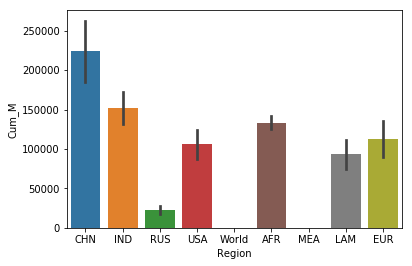

In [42]:
dat = allmodels_df.loc[(allmodels_df.Year == 2100) & (allmodels_df.MODEL == 'IMAGE')]

sns.barplot(x = 'Region', y = 'Cum_M', data = dat)

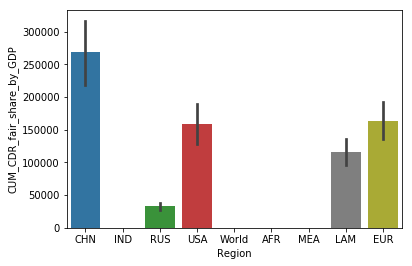

In [39]:
dat = allmodels_df.loc[allmodels_df.Year == 2100]
sns.barplot(x = 'Region', y = 'CUM_CDR_fair_share_by_GDP', data = dat)